# Developing NIDS on normal dataset

To demonstrate the impact of adversarial attacks generated by our tool (NRT), we first train various machine learning-based Network Intrusion Detection Systems (NIDS) on a processed dataset file. Four distinct PCAPs—benign, dos_syn, ddos_icmp, and SQL injection—were processed using our UMNIDS tool to create a file named normal_data.csv. This file includes the processed flow, payload, and labels provided with the dataset.

In [76]:
import pandas as pd
df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')

C:\Users\syedwali\AppData\Local\Temp\ipykernel_544\3285948799.py:2: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\normal_data.csv')


In [77]:
df['label'].value_counts()

label
dos_syn      66201
benign       14892
sqli          2755
ddos_icmp      433
Name: count, dtype: int64

In [78]:
# Step 1: Get the count of instances per class
target_instances = 2500
# Step 2: Undersample or oversample each class to have exactly 2500 instances
balanced_df = pd.DataFrame()  # Empty dataframe to store balanced data

for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    
    # If class has more than 2500 instances, undersample
    if len(class_subset) > target_instances:
        class_subset = class_subset.sample(target_instances, random_state=42)
    
    # If class has less than 2500 instances, oversample
    #elif len(class_subset) < target_instances:
    #    class_subset = class_subset.sample(target_instances, replace=True, random_state=42)
    
    # Append the balanced class subset to the balanced dataframe
    balanced_df = pd.concat([balanced_df, class_subset])

# Reset index of the final balanced dataframe
df = balanced_df.reset_index(drop=True)
print(df['label'].value_counts())
# Now balanced_df contains 2500 instances per class in df['label']


label
benign       2500
dos_syn      2500
sqli         2500
ddos_icmp     433
Name: count, dtype: int64


Now, we will convert the udps.payload_data feature provided by the UM-NIDS tool into byte-level decimal values. This transformation will enable us to use the data to train various payload-based classifiers.

In [79]:
import ast

# Function to convert hex string into a list of integers at byte level (2 hex chars = 1 byte)
def hex_to_int_list_byte_level(hex_str):
    # Convert the string representation of a list to an actual list
    hex_list = ast.literal_eval(hex_str)
    int_list = []
    
    for hex_string in hex_list:
        # Split the hex string into 2-character chunks (1 byte = 2 hex chars)
        byte_chunks = [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]
        # Convert each byte (2 hex chars) into its decimal equivalent and append to list
        int_list.extend([int(byte, 16) for byte in byte_chunks])
    
    return int_list

# Apply this function to each entry in the 'udps.payload_data' column
df['udps.payload_data_converted'] = df['udps.payload_data'].apply(hex_to_int_list_byte_level)

# This will add a new column 'udps.payload_data_converted' with the byte-level decimal values


We will truncate or pad the payload data to ensure a fixed length, making it suitable for training classifiers.

In [80]:
import numpy as np

# Define the target length
target_length = 12000

# Function to truncate or pad the payload data
def truncate_or_pad(array):
    # Truncate if length is greater than target_length
    if len(array) > target_length:
        return array[:target_length]
    # Pad with zeros if length is less than target_length
    elif len(array) < target_length:
        return np.pad(array, (0, target_length - len(array)), 'constant')
    return array

# Apply the function to the payload data column
df['udps.payload_data_fixed'] = df['udps.payload_data_converted'].apply(truncate_or_pad)

# Now, df['udps.payload_data_fixed'] contains the truncated/padded arrays


To demonstrate the versatility of the attack, we are also transforming the payload into string or ASCII format. This allows us to evaluate payload classifiers based on both decimal values and textual ASCII strings against adversarial samples generated by our attack. The subsequent code converts hex values into cleaned ASCII strings, which can then be used to train a TF-IDF vectorizer, ultimately enabling the training of ML-based NIDS.

In [103]:
import pandas as pd
from sklearn.utils import resample
import ast
import string
from tqdm import tqdm

# Function to convert hex values to ASCII string
def hex_to_ascii(hex_list):
    ascii_str = ''

    # Process each hex value (hex_list is expected to be a list of hex strings)
    for hex_val in hex_list:
        # Split each hex value into pairs and convert them to ASCII characters
        ascii_str += ''.join([chr(int(hex_val[i:i+2], 16)) for i in range(0, len(hex_val), 2)])
    
    # Filter out non-printable characters
    filtered_str = ''.join(filter(lambda x: x in string.printable, ascii_str))
    
    return filtered_str

# Assuming df is your DataFrame containing the 'udps.payload_data' column
# Convert each string representation to a list
df['udps.payload_data_parsed'] = df['udps.payload_data'].apply(ast.literal_eval)

# Apply hex_to_ascii function to the parsed data with a tqdm progress bar for DataFrame rows
tqdm.pandas(desc="Processing rows")

# Apply the hex_to_ascii function with progress tracking for rows
df['string'] = df['udps.payload_data_parsed'].progress_apply(hex_to_ascii)

# Identify rows where the 'string' column is empty or contains only whitespace
empty_rows = df['string'].str.strip().eq('')

# Get the indices of the rows to be dropped
indices_to_drop = empty_rows[empty_rows].index

# Drop the rows from the DataFrame
s = df.drop(indices_to_drop)

# Reset the index after dropping rows
s.reset_index(drop=True, inplace=True)

# Check the modified DataFrame
print(f"Number of rows dropped: {len(indices_to_drop)}")
#print("Modified DataFrame:\n", s.head())


Processing rows: 100%|████████████████████████████████████████████████████████████| 7933/7933 [00:12<00:00, 635.13it/s]

Number of rows dropped: 2614


In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
f=s.dropna(subset=['label'])
# Assuming 'data' contains the 'string' and 'label' columns
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split((f), f['label'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer on the training data and transform both train and test data
X_train_tfidf = tfidf.fit_transform(X_train['string'])
#X_test_tfidf = tfidf.transform(X_test['string'])

# Initialize the Random Forest Classifier with parallel processing (n_jobs=-1)
rf_classifier_tfidf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the classifier on the TF-IDF features and labels
rf_classifier_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [105]:
# Make predictions on the test set
X_test_tfidf = tfidf.transform(X_test['string'])
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,digits=4))

Accuracy: 0.9154
Classification Report:
              precision    recall  f1-score   support

      benign     0.9340    1.0000    0.9659       495
   ddos_icmp     0.7568    0.3590    0.4870        78
     dos_syn     1.0000    0.6667    0.8000         3
        sqli     0.9071    0.9201    0.9135       488

    accuracy                         0.9154      1064
   macro avg     0.8994    0.7364    0.7916      1064
weighted avg     0.9088    0.9154    0.9063      1064



## payload based NIDS 

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
# Assuming df is already defined and has a 'label' column
X = np.array(df['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y = df['label']  # Labels

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize the Random Forest Classifier
clf_payload = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)

# Train the classifier
clf_payload.fit(X_train, y_train)

# Predict on the test set
y_pred = clf_payload.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.9298
Classification Report:
              precision    recall  f1-score   support

      benign     0.9870    0.9621    0.9744       791
   ddos_icmp     0.5833    0.3307    0.4221       127
     dos_syn     0.9465    0.9918    0.9686       732
        sqli     0.8883    0.9370    0.9120       730

    accuracy                         0.9298      2380
   macro avg     0.8513    0.8054    0.8193      2380
weighted avg     0.9228    0.9298    0.9240      2380



### Adversarial Testing with Benign Payload

First, we test the impact of SQL adversarial samples by adding benign SQL terms in the comment section instead of random payloads. The manipulated PCAP is then processed using the UMNIDS tool to convert it into a CSV file, which we are reading in the following code section

In [61]:
def balancer(df,target_instances):
    # Empty dataframe to store balanced data
    balanced_df = pd.DataFrame()
    for label in df['label'].unique():
        class_subset = df[df['label'] == label]
        
        # If class has more than 2500 instances, undersample
        if len(class_subset) > target_instances:
            class_subset = class_subset.sample(target_instances, random_state=42)
        
        # Append the balanced class subset to the balanced dataframe
        balanced_df = pd.concat([balanced_df, class_subset])
    return balanced_df.reset_index(drop=True)

In [95]:
import pandas as pd
df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\SQL\\benign Payload\\processed\\sql_processed.csv')
df2['label']='sqli'
attacker_mac = ['e4:5f:01:55:90:c4', 'dc:a6:32:dc:27:d5', 'dc:a6:32:c9:e4:ab', 'dc:a6:32:c9:e5:a4',
        'ac:17:02:05:34:27', 'dc:a6:32:c9:e4:d5', 'dc:a6:32:c9:e5:ef', 'dc:a6:32:c9:e4:90',
        'b0:09:da:3e:82:6c']
df2=df2[df2['src_mac'].isin(attacker_mac)]
df2['label'].value_counts()

label
sqli    381
Name: count, dtype: int64

In [96]:
df2['udps.payload_data_converted'] = df2['udps.payload_data'].apply(hex_to_int_list_byte_level)

In [97]:
df2['udps.payload_data_fixed'] = df2['udps.payload_data_converted'].apply(truncate_or_pad)

In [98]:
X_test = np.array(df2['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y_test = df2['label']  # Labels


Classifier: Random Forest
**************************************************
Classification Report:
              precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
     dos_syn     0.0000    0.0000    0.0000         0
        sqli     1.0000    0.3622    0.5318       381

    accuracy                         0.3622       381
   macro avg     0.3333    0.1207    0.1773       381
weighted avg     1.0000    0.3622    0.5318       381



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


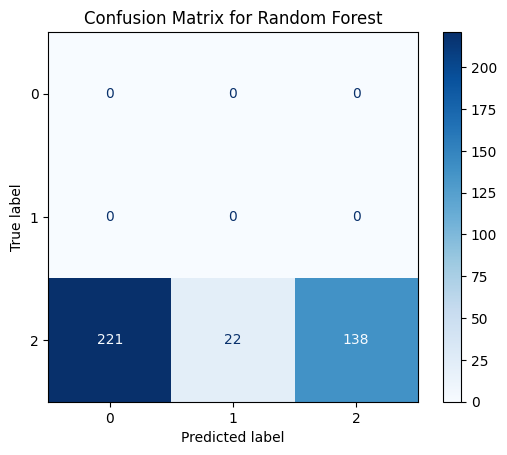

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
X = np.array(df2['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y = df2['label']  # Labels
y2 = y.map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2,'sqli':3})
# List of trained classifiers with their names for easy iteration
classifiers = {
    "Random Forest": clf_payload,
   # "Gradient Boosting": clf_gbm,
    #"XGB": clf_xgb,
    #"LGB": clf_lgb,
   # "MLP": clf_mlp,    
}

# Iterate through each classifier, predict, and print results
for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    print("*"*50)
    try:
        # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y, y_pred, digits=4)
        cm = confusion_matrix(y, y_pred)
    except:
         # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y2, y_pred, digits=4)
        cm = confusion_matrix(y2, y_pred)
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


In [67]:
df2['udps.payload_data_parsed'] = df2['udps.payload_data'].apply(ast.literal_eval)

# Apply hex_to_ascii function to the parsed data with a tqdm progress bar for DataFrame rows
tqdm.pandas(desc="Processing rows")

# Apply the hex_to_ascii function with progress tracking for rows
df2['string'] = df2['udps.payload_data_parsed'].progress_apply(hex_to_ascii)

# Identify rows where the 'string' column is empty or contains only whitespace
empty_rows = df2['string'].str.strip().eq('')

# Get the indices of the rows to be dropped
indices_to_drop = empty_rows[empty_rows].index

# Drop the rows from the DataFrame
s = df2.drop(indices_to_drop)

# Reset the index after dropping rows
s.reset_index(drop=True, inplace=True)

# Check the modified DataFrame
print(f"Number of rows dropped: {len(indices_to_drop)}")
#print("Modified DataFrame:\n", s.head())

Processing rows: 100%|█████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 1088.57it/s]

Number of rows dropped: 22


In [68]:

f=s.dropna(subset=['label'])


# Fit the vectorizer on the training data and transform both train and test data
X_tfidf = tfidf.transform(f['string'])
y_pred = rf_classifier_tfidf.predict(X_tfidf)

# Evaluate the classifier's performance
accuracy = accuracy_score(f['label'], y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(f['label'], y_pred))


Accuracy: 0.3231
Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
        sqli       1.00      0.32      0.49       359

    accuracy                           0.32       359
   macro avg       0.50      0.16      0.24       359
weighted avg       1.00      0.32      0.49       359



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


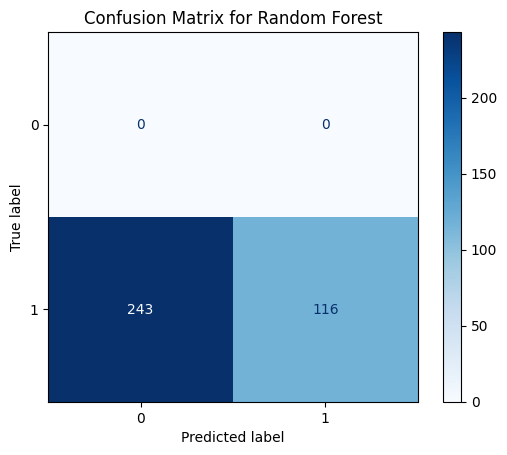

In [69]:
cm = confusion_matrix(f['label'], y_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {name}')
plt.show()

### Adversarial Testin Random Payload

Next, we are testing the impact of SQL adversarial samples by adding random payloads in the comment sections of SQL queries. The manipulated PCAP is then processed using the UMNIDS tool to convert it into a CSV file, which we evaluate in the following code section.

In [100]:
import pandas as pd
df2=pd.read_csv('C:\\Users\\syedwali\\Downloads\\adversarial\\Attacks\\SQL\\Random Payload\\processed\\sql_processed.csv')
df2['label']='sqli'
attacker_mac = ['e4:5f:01:55:90:c4', 'dc:a6:32:dc:27:d5', 'dc:a6:32:c9:e4:ab', 'dc:a6:32:c9:e5:a4',
        'ac:17:02:05:34:27', 'dc:a6:32:c9:e4:d5', 'dc:a6:32:c9:e5:ef', 'dc:a6:32:c9:e4:90',
        'b0:09:da:3e:82:6c']
df2=df2[df2['src_mac'].isin(attacker_mac)]
df2['label'].value_counts()

label
sqli    381
Name: count, dtype: int64

In [101]:
df2['udps.payload_data_converted'] = df2['udps.payload_data'].apply(hex_to_int_list_byte_level)
df2['udps.payload_data_fixed'] = df2['udps.payload_data_converted'].apply(truncate_or_pad)


Classifier: Random Forest
**************************************************
Classification Report:
              precision    recall  f1-score   support

      benign     0.0000    0.0000    0.0000         0
     dos_syn     0.0000    0.0000    0.0000         0
        sqli     1.0000    0.6247    0.7690       381

    accuracy                         0.6247       381
   macro avg     0.3333    0.2082    0.2563       381
weighted avg     1.0000    0.6247    0.7690       381



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


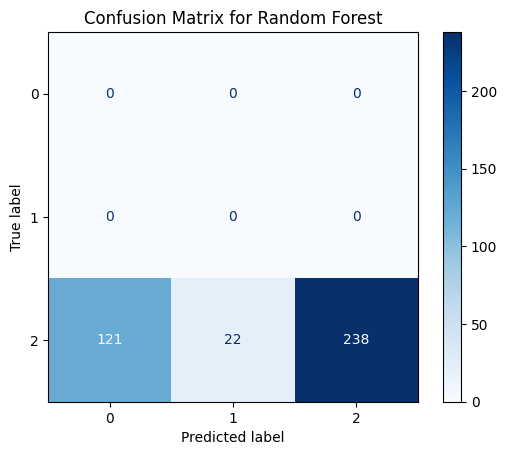

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
X = np.array(df2['udps.payload_data_fixed']).tolist()  # Features (drop the label column)
y = df2['label']  # Labels
y2 = y.map({'benign': 0, 'dos_syn': 1,'ddos_icmp':2,'sqli':3})
# List of trained classifiers with their names for easy iteration
classifiers = {
    "Random Forest": clf_payload,
    #"Gradient Boosting": clf_gbm,
    #"XGB": clf_xgb,
    #"LGB": clf_lgb,
   # "MLP": clf_mlp,    
}

# Iterate through each classifier, predict, and print results
for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    print("*"*50)
    try:
        # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y, y_pred, digits=4)
        cm = confusion_matrix(y, y_pred)
    except:
         # Predict on the test set
        y_pred = clf.predict(X)
        # Evaluate the model
        report = classification_report(y2, y_pred, digits=4)
        cm = confusion_matrix(y2, y_pred)
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


In [73]:
df2['udps.payload_data_parsed'] = df2['udps.payload_data'].apply(ast.literal_eval)

# Apply hex_to_ascii function to the parsed data with a tqdm progress bar for DataFrame rows
tqdm.pandas(desc="Processing rows")

# Apply the hex_to_ascii function with progress tracking for rows
df2['string'] = df2['udps.payload_data_parsed'].progress_apply(hex_to_ascii)

# Identify rows where the 'string' column is empty or contains only whitespace
empty_rows = df2['string'].str.strip().eq('')

# Get the indices of the rows to be dropped
indices_to_drop = empty_rows[empty_rows].index

# Drop the rows from the DataFrame
s = df2.drop(indices_to_drop)

# Reset the index after dropping rows
s.reset_index(drop=True, inplace=True)

# Check the modified DataFrame
print(f"Number of rows dropped: {len(indices_to_drop)}")
#print("Modified DataFrame:\n", s.head())

Processing rows: 100%|█████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 1656.52it/s]

Number of rows dropped: 22


In [74]:

f=s.dropna(subset=['label'])


# Fit the vectorizer on the training data and transform both train and test data
X_tfidf = tfidf.transform(f['string'])
y_pred = rf_classifier_tfidf.predict(X_tfidf)

# Evaluate the classifier's performance
accuracy = accuracy_score(f['label'], y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(f['label'], y_pred))


Accuracy: 0.9666
Classification Report:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
        sqli       1.00      0.97      0.98       359

    accuracy                           0.97       359
   macro avg       0.50      0.48      0.49       359
weighted avg       1.00      0.97      0.98       359



C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\syedwali\.conda\envs\cuda_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


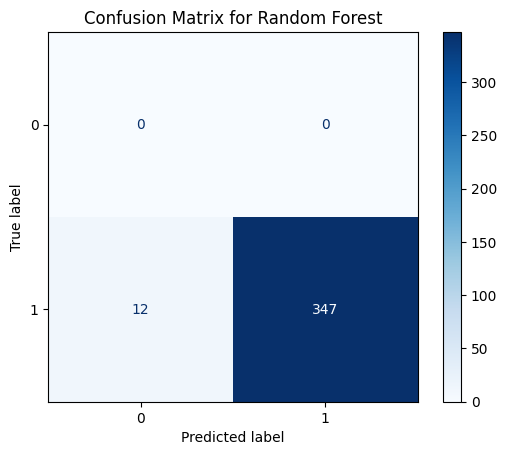

In [75]:
cm = confusion_matrix(f['label'], y_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {name}')
plt.show()